(example-mccaffrey)=
# McCaffrey Plume Experiments

## Introduction

Here, we provide a proposal as to how one could organise their simulation projects. Projects can be anything, from work for a thesis or in context of a simulation campaign in the industry. 

In this example, the directory for our project is called `FirePlumes`. Inside the project directory, three other directories are created: one to store the jupyter notebooks `RunReports`, one for the simulations `McCaffrey`, and one for general information `GeneralInformation`. The simulations are based on the different setups of the [McCaffrey plume experiments](https://nvlpubs.nist.gov/nistpubs/Legacy/IR/nbsir79-1910.pdf), which are proposed and discussed in the [Extra Task: Simulation of a purely buoyant diffusion flame](extra-task).

In general, it could be useful to distribute different aspects of the project over different jupyter notebooks. Consider, for example, one were to compare experiment data to simulation results. One notebook could be used to pre-process the data from the experiment, one could be used to prepare the simulation input and one could be used to compare the results.

In `RunReports`, sub-directories are created by the notebooks to store their respective results. File and directory labels are used to control the flow of reading the data. The data is organised in Python dictionaries. An external Python script is provided to store functions used in the notebook in an effort to keep it relatively clean. The `reload` module from the `importlib` package is used to reload the `Processing.py` script during runtime of the notebook. This allows to add functions to `Processing.py`, while designing the content of the `RunReport` notebook and load them without need to restart the respective kernel. 

In [2]:
import os
import matplotlib
import Processing as pro

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload


# Reload Python modules for changes that occured during runtime.
reload(pro);

Sometimes it is helpful to keep track of the versions of the used packages. This can be accomplished with the following input.

In [3]:
print('Package Versions')
print('----------------')
print('Pandas version: {}'.format(pd.__version__))
print('Numpy version: {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))

Package Versions
----------------
Pandas version: 1.4.2
Numpy version: 1.22.3
Matplotlib version: 3.5.2


It is also helpful to have the current working directory stored in a variable for easy access.

In [4]:
# Get current working directory.
cwd = os.getcwd()
#print(cwd)

In the following code block general information necessary for this notebook is stored. For example, path to different directories that contain static information, such as directories containing experiment data or path fragments to different sub-sets of simulations. 

Furthermore, functionality is provided that creates an output directory, if it does not exist. The path to this output directory is stored in a variable for easy access during this norebook. When keeping the same strategy across similar notebooks for different projects, one only needs to adjust the directory lable in this cell and can always call the respective variable. 

In [5]:
# General information used in this notebook.


# Define path to McCaffrey simulations.
mcc_sim_path = os.path.join("..", "McCaffrey")


# Path do experiment data.
exp_dir = os.path.join("..", "GeneralInformation")
# Idealised temperature.
mcc_ideal_temp_path = os.path.join(exp_dir, "McCaffreyIdealiesdTemp.csv")
mcc_idealised_temp = pd.read_csv(mcc_ideal_temp_path, header=0)

# HRR in the experiments.
exp_hrrs = {
    "14kW": 14.4, 
    "22kW": 21.7, 
    "33kW": 33.0, 
    "45kW": 44.9, 
    "57kW": 57.5}


# Initialise data collection.
plume_sims = dict()
plume_sims["McCaffrey"] = dict()


# Directory used to collect the output produced by this notebook.
output_dir = "RunReportMcCaffreyOutput"
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print("* Output directory created.")
else:
    print("* Output directory already exists.")

* Output directory already exists.


Some basic computation to determine the `DEVC` locations that are used throughout this notebook.

In [6]:
# DEVC heights.
# Parameters for the collection.
start = 30  # in millimeter
distance = 60  # in millimeter
n_devc = 58

# Initialise result collection.
devc_heights = list()

# Calculate DEVC heights.
for n_devc in range(n_devc):
    height = (start + n_devc * distance) / 1000  # transform to meter
    devc_heights.append(height)

# Read Simulation Data

Here, we read the simulation results and store them in a Python dictionary. The basic dictionary was initialised in the General section above. We add dictionaries to the "McCaffrey" section, where we use the directory labels as keys. Also the directory labels match the keys in the `exp_hrrs` notebook. Thus, we can easily pull in the reported HRRs from the experiments, provided they are in the General section. 

In [7]:
# Get the resolution directory labels.
dir_res_labels = os.listdir(mcc_sim_path)

# 
for dir_res_label in dir_res_labels:
    # Build path for the HRR simulations.
    res_path = os.path.join(mcc_sim_path, dir_res_label)
    
    # Get the HRR subdirectory labels.
    dir_hrr_labels = os.listdir(res_path)
    
    # Add dictionaries for the resolutions.
    plume_sims["McCaffrey"][dir_res_label] = dict()
    
    # For better readability (shorter lines).
    data_collection = plume_sims["McCaffrey"][dir_res_label]
    
    # Prepare the dictionary for result collection.
    for dir_hrr_label in dir_hrr_labels:
        data_collection[dir_hrr_label] = dict()
        data_collection[dir_hrr_label]["Exp. HRR"] = exp_hrrs[dir_hrr_label]

In [8]:
# Check result.
plume_sims["McCaffrey"]

{'6cm': {'14kW': {'Exp. HRR': 14.4},
  '22kW': {'Exp. HRR': 21.7},
  '57kW': {'Exp. HRR': 57.5},
  '33kW': {'Exp. HRR': 33.0},
  '45kW': {'Exp. HRR': 44.9}}}

Now, the `*_hrr.csv` and `*_devc.csv` files for each simulation can be read as Pandas DataFrames. Since the dictionary and directory labels match, they can be used to control the loop to crawl through the different directories. 

This code block is set up such that it checks if the respective files exist and handles cases where they are not. This is specifically helpful when one would like to intermittently look into the results, while setting up the notebook to process them.

In [9]:
# Get resolution directory labels from dict keys.
dir_res_labels = list(plume_sims["McCaffrey"])


for res_label in dir_res_labels:
    # Get simulation directory labels from dict keys.
    dir_labels = list(plume_sims["McCaffrey"][res_label])

    # Crawl through the different simulation directories.
    for dir_label in dir_labels:
        # Read DEVC data as Pandas DataFrame.
        # Build path.
        devc_path = os.path.join(mcc_sim_path, 
                                 res_label, 
                                 dir_label, 
                                 f"mcc_{dir_label}_devc.csv")
        # Check if file exists.
        if os.path.isfile(devc_path):
            # Read file.
            devc_df = pd.read_csv(devc_path, header=1)
        else:
            devc_df = None

        # Read HRR data as Pandas DataFrame.
        # Build path.
        hrr_path = os.path.join(mcc_sim_path, 
                                res_label, 
                                dir_label, 
                                f"mcc_{dir_label}_hrr.csv")
        # Check if file exists.
        if os.path.isfile(hrr_path):
            # Read file.
            hrr_df = pd.read_csv(hrr_path, header=1)
        else:
            hrr_df = None


        # Collect results.
        plume_sims["McCaffrey"][res_label][dir_label]["DEVC"] = devc_df
        plume_sims["McCaffrey"][res_label][dir_label]["HRR"] = hrr_df

A benefit of storing the results in a dictionary is the way individual pieces of information are accessed, see below. The keys of a dictionary are strings, thus when choosen wisely it is obvious for humans which data set is requested. This is very helpful when looking for errors. Of course one could read the results as multi-dimensional arrays. However, there you would need to access the information by position, which is much less intuitive and can be error prone. 

Consider:

`plume_sims["McCaffrey"]["14kW"]["HRR"]`

in comparison to:

`plume_sims[23][5][42]`

Surely, if one is to work with gigantic data sets, arrays may be better for computational efficiency. However, the data sets we use regularily are small enough that slightly negative effects on computing time are outweight by more explicit inputs (writing words to get specific data sets) and easier debugging. 

In [10]:
# Check result:
plume_sims["McCaffrey"]["6cm"]["14kW"]["HRR"].head()

,Time,HRR,Q_RADI,Q_CONV,Q_COND,Q_DIFF,Q_PRES,Q_PART,Q_ENTH,Q_TOTAL,MLR_AIR,MLR_METHANE,MLR_PRODUCTS
0,0.000000,0.000000,-1.067943e-07,-2.568131e-10,0.000000,0.000000,0.0,0.0,0.000000,-1.070511e-07,0.0,0.000000,0.0
1,0.370328,2.128356,-1.393241e-01,3.394389e-02,-0.011482,-0.000290,0.0,0.0,1.250592,2.011203e+00,0.0,0.000059,0.0
2,0.694365,8.307317,-2.535417e+00,9.398008e-02,-0.179315,-0.000784,0.0,0.0,5.668750,5.685782e+00,0.0,0.000145,0.0
3,1.008729,9.753047,-1.932712e+00,1.311288e-01,-0.118915,-0.001158,0.0,0.0,7.538772,7.831391e+00,0.0,0.000202,0.0
4,1.340284,11.468659,-1.952889e+00,1.596306e-01,-0.120110,-0.001324,0.0,0.0,9.512996,9.553967e+00,0.0,0.000239,0.0


# Plot results

Having read all the data, we can now create some plots. 

At first we check if we set up the HRR correctly. For that access the HRR data for the individual simulations and plot it over time. We can also use the experiment HRR data in the dictionary to plot a visual aid on the fly. This aid is called "Target". Furthermore, the directory labels can be used to build the data series labels.

Note: we introduced another variable, `data_series_label`, with which we could easily control to read different simulation sets. For example if we were to simulate an experiment series, maybe for larger energy release rates.

## Cell Resolution: 6 cm

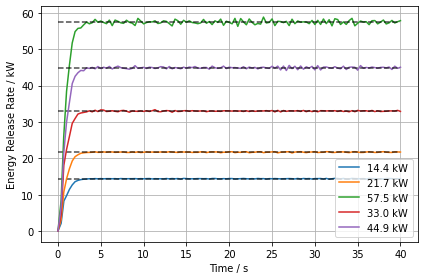

In [11]:
# Get simulation directory labels.
data_series_label = "McCaffrey"
resolution_label = "6cm"

data_sets = plume_sims[data_series_label][resolution_label]
dir_labels = list(data_sets)


for dir_label in dir_labels:
    # Get data set.
    data_set = data_sets[dir_label]
    
    
    target_hrr = data_set["Exp. HRR"]
    unit = dir_label[2:]
    # Get DataFrame.
    hrr_data = data_set["HRR"]
    
    if hrr_data is not None:
        # Plot HRR data.
        plt.plot(hrr_data.Time,
                 hrr_data.HRR,
                 label=f"{target_hrr} {unit}")
        
        # Plot target.
        plt.plot([0,40], 
                 [target_hrr, target_hrr],
                 color='k', alpha=0.7,
                 linestyle="--")
    else:
        # Skip, because no data exists yet.
        continue
    
    
# Plot meta data.
plt.xlabel("Time / s")
plt.ylabel("Energy Release Rate / kW")

plt.legend()
plt.grid()
plt.tight_layout()


# Save image.
file_label = f"PlumeSim_{resolution_label}_{data_series_label}_HRR.png"
plot_path = os.path.join(output_dir, 
                         file_label)
plt.savefig(plot_path, dpi=320)

Here we plot the `DEVC` that are highest above the burner surface to assess if they have reached a steady state. With this we could assess the simulation duration `T_END`.

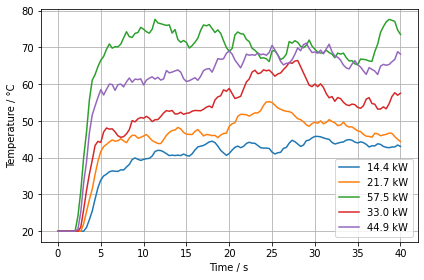

In [12]:
# Get simulation directory labels.
data_series_label = "McCaffrey"
resolution_label = "6cm"

data_sets = plume_sims[data_series_label][resolution_label]
dir_labels = list(data_sets)


for dir_label in dir_labels:
    # Get data set.
    data_set = data_sets[dir_label]
    
    
    target_hrr = data_set["Exp. HRR"]
    unit = dir_label[2:]
    # Get DataFrame.
    devc_data = data_set["DEVC"]
    
    if devc_data is not None:
        # Plot HRR data.
        plt.plot(devc_data.Time,
                 devc_data["TC.057"],
                 label=f"{target_hrr} {unit}")
    else:
        # Skip, because no data exists yet.
        continue
    
    
# Plot meta data.
plt.xlabel("Time / s")
plt.ylabel("Temperature / °C")

plt.legend()
plt.grid()
plt.tight_layout()


# Save image.
file_label = f"PlumeSim_{resolution_label}_{data_series_label}_TempDEVC.png"
plot_path = os.path.join(output_dir, 
                         file_label)
plt.savefig(plot_path, dpi=320)

Finally we process the data series from the individual devices and plot the results. The temperature device locations are normalised with the HRR to make them comparable. The general behaviour can apparently be reproduced. Higher fluid cell resolutions should lead to better results.

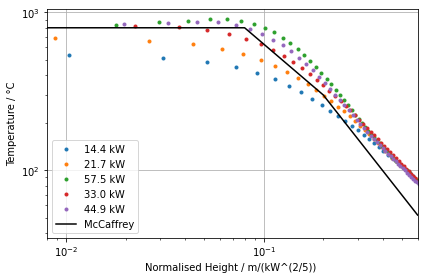

In [13]:
# Get simulation directory labels.
data_series_label = "McCaffrey"
resolution_label = "6cm"

data_sets = plume_sims[data_series_label][resolution_label]
dir_labels = list(data_sets)


for dir_label in dir_labels:
    # Get data set.
    data_set = data_sets[dir_label]
    target_hrr = data_set["Exp. HRR"]
    unit = dir_label[2:]
    
    # Initialise result collection.
    temperatures = list()
    norm_heights = list()
    
    # Check if data exists.
    if data_set["DEVC"] is not None:    
        # Calculate temperature averages.
        headers = list(data_set["DEVC"])
        for header in headers:
            if "TC." in header:
                # Average over the last 5 seconds.
                avrg_temp = np.average(data_set["DEVC"][header][-15:])
                temperatures.append(avrg_temp)

        # Calculate normalised heights.
        for devc_height in devc_heights:
            norm_height = pro.McCaffreyHeight(devc_height, 
                                              target_hrr)
            norm_heights.append(norm_height)


        plt.plot(norm_heights, temperatures, '.',
                     label=f"{target_hrr} {unit}")
    else:
        # Skip.
        continue
    
    
plt.plot(mcc_idealised_temp.Height,
         mcc_idealised_temp.Temperature,
         color='k',
         label='McCaffrey')


plt.xscale('log')
plt.yscale('log')
plt.xlim(0.008, 0.6)

plt.ylabel('Temperature / °C')
plt.xlabel('Normalised Height / m/(kW^(2/5)) ')

plt.legend()
plt.grid()
plt.tight_layout()


# Save image.
file_label = f"PlumeSim_{resolution_label}_{data_series_label}_Temp.png"
plot_path = os.path.join(output_dir, 
                         file_label)
plt.savefig(plot_path, dpi=320)